## Comparison of London boroughs for families with children seeking to move to London

**NOTE: Github does not always correctly display the maps. Please also refer to the Notebook on IBM cloud in order to see any missing maps. Link is below:**

https://eu-gb.dataplatform.cloud.ibm.com/analytics/notebooks/v2/8ac86527-2560-4441-9232-45443030a750/view?access_token=42fa319857ec245e4039ee4412294d6d2910f5b37dc153754c2c2202e7659749


### Introduction/Business Problem

Many people come to London to live and work. Often they are bringing pre-school or school-aged children to settle in the UK’s capital. However, because of the high costs associated with living in the centre of London, many people search for accommodation in the suburbs.

There are 32 London boroughs, each with its own characteristics and charm. For newcomers it can be difficult to know where to focus their search for accommodation, especially if they have diverse needs such as entertainment, parks, and good schools for their children.

There is a need amongst newcomers to London to better understand the different boroughs so that they can make an informed decision when choosing an area in which to live and raise children. The target audience would be families that include children, who would be interested in this topic because they are keen to understand not only the vibe of each borough, but also the quality of local schools.

### Data

In order to identify the London boroughs, data from a list on the following Wikipedia page will be scraped: https://en.wikipedia.org/wiki/London_boroughs

Coordinates will then be appended using a Python package

Foursquare location data will be used to examine and cluster the different boroughs of London to understand which could be more suitable for a family based on the prevalence of different amenities in the borough.

I will additionally append UK government data on GSCE results by London borough (see note below), found at the following location: https://data.london.gov.uk/dataset/gcse-results-by-borough in order to complete the analysis and visualise the findings.

Note: The GCSE is the General Certificate of Secondary Education, an English qualification demonstrating completion of secondary education (to age 16). GCSE results are often used to assess and rank the performance of secondary schools in England.

### Methodology

In [155]:
#Import requests and beautifulsoup packages that will be used for web scraping - perform web scraping of Wikipedia page

import requests
website_url = requests.get('https://en.wikipedia.org/wiki/London_boroughs').text

from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,'lxml')

In [156]:
#Identify table within Wikipedia page
boroughs = soup.find('table',{'class':'wikitable sortable'})

In [157]:
#Read the table into a Pandas data frame
import pandas as pd
boroughs_1 = pd.read_html(str(boroughs), header=0)
boroughs_df = pd.DataFrame(boroughs_1[0])

In [158]:
#Rename a column
boroughs_df.rename(columns={'London borough':'Borough'}, 
                 inplace=True)

In [159]:
#Remove unwanted additional columns
boroughs_df = boroughs_df.drop(boroughs_df.columns[[2, 3, 4, 5, 6]], axis=1)

In [160]:
#Clean some text strings to remove unwanted characters
boroughs_df['Borough'] = boroughs_df['Borough'].str.replace("[notes 2]",'', regex = False)
boroughs_df['Borough'] = boroughs_df['Borough'].str.replace("[notes 3]",'', regex = False)

In [161]:
#Print the data frame
boroughs_df.head()

,Borough,Designation
0,Greenwich,Inner
1,Hackney,Inner
2,Hammersmith,Inner
3,Islington,Inner
4,Kensington and Chelsea,Inner


In [162]:
#Get latitude and longitude coordinates by importing a Google Sheets document
latlng = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR9AmpkPVmc1PKBfhxeDZ3O2GFGGp02P225NbvGhWWKtcDuPdieQsON3fxVbRp3q8hszBe64YtgtnzO/pub?gid=0&single=true&output=csv')

In [163]:
#Join the data sources and remove unwanted columns - print the resulting data frame
london_boroughs = pd.merge(boroughs_df, latlng, how='left',
        left_on='Borough', right_on='Borough', validate="1:1")

london_boroughs = london_boroughs.drop(london_boroughs.columns[[2, 3, 4]], axis=1)
london_boroughs.head()

,Borough,Designation,Latitude,Longitude
0,Greenwich,Inner,51.493367,0.009821
1,Hackney,Inner,51.573445,-0.072438
2,Hammersmith,Inner,51.491187,-0.223731
3,Islington,Inner,51.546506,-0.105806
4,Kensington and Chelsea,Inner,51.499080,-0.193825


In [164]:
#Import the school performance data by borough from the London Open Data website and rename some of the boroughs so that tables can be joined in next step
gcse = pd.read_csv('https://data.london.gov.uk/download/gcse-results-by-borough/12a95356-81d3-49d6-8a13-e41b62f5e5c4/gcse-results.csv')
gcse.drop(gcse[gcse['Year'] != '2016/17'].index, inplace = True)
gcse.drop(gcse[gcse['Sex'] != 'All'].index, inplace = True)
gcse.rename(columns={'Area':'Borough','Attainment8':'Score'}, inplace=True)
gcse['Borough'] = gcse['Borough'].str.replace("Barking and Dagenham",'Barking', regex = False)
gcse['Borough'] = gcse['Borough'].str.replace("Hammersmith and Fulham",'Hammersmith', regex = False)
gcse = gcse.drop(gcse.columns[[0, 2, 3, 4, 6]], axis=1)

In [165]:
#Join the data
data = pd.merge(london_boroughs, gcse, how='left',
        left_on='Borough', right_on='Borough', validate="1:1")

In [166]:
#London boroughs are categorised as Inner and Outer. We will drop the Inner boroughs as these are not interesting to the family in our use case - this way we focus only on the suburbs
#Print the resulting data frame with all relevant boroughs, their coordinates, and average school performance score
data.drop(data[data['Designation'] != 'Outer'].index, inplace = True)
data['Score'] = pd.to_numeric(data['Score'])
data.sort_values('Score', ascending = False, inplace= True)
data.head()

,Borough,Designation,Latitude,Longitude,Score
29,Sutton,Outer,51.361428,-0.193961,56.2
24,Kingston upon Thames,Outer,51.412330,-0.300689,55.5
12,Barnet,Outer,51.625149,-0.152936,54.7
28,Richmond upon Thames,Outer,51.461311,-0.303742,52.7
27,Redbridge,Outer,51.590119,0.081913,51.2


In [92]:
#Install mapping package
!pip install folium

In [93]:
#Import mapping package
import folium

In [94]:
#Install geocoder
!pip install geocoder

In [167]:
#Import geocoder and define coordinates for London
import geocoder
g = geocoder.osm('London, United Kingdom')
g.latlng
latitude = g.latlng[0]
longitude = g.latlng[1]

In [168]:
#Visualise boroughs on a map
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, borough in zip(data['Latitude'], data['Longitude'], data['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
map_london

In [169]:
# The code was removed by Watson Studio for sharing.

In [170]:
#Get nearby venues for each borough from Foursquare
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [172]:
#List the boroughs
venues = getNearbyVenues(names=data['Borough'],
                                   latitudes=data['Latitude'],
                                   longitudes=data['Longitude']
                                  )

Sutton
Kingston upon Thames
Barnet
Richmond upon Thames
Redbridge
Merton
Bromley
Harrow
Bexley
Brent
Ealing
Newham
Hounslow
Havering
Hillingdon
Barking
Haringey
Enfield
Waltham Forest
Croydon


In [173]:
#Display venues as a data frame
print(venues.shape)
venues.head()

(1499, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sutton,51.361428,-0.193961,Shinner & Sudtone,51.361898,-0.192486,Pub
1,Sutton,51.361428,-0.193961,Nando's,51.360156,-0.191707,Portuguese Restaurant
2,Sutton,51.361428,-0.193961,Manor Park,51.362751,-0.190394,Park
3,Sutton,51.361428,-0.193961,Caffè Nero,51.361214,-0.191936,Coffee Shop
4,Sutton,51.361428,-0.193961,Go-Gym,51.360355,-0.195039,Gym


In [174]:
#Count the number of venues in each borough
venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Barking,68,68,68,68,68,68
Barnet,90,90,90,90,90,90
Bexley,42,42,42,42,42,42
Brent,100,100,100,100,100,100
Bromley,61,61,61,61,61,61
Croydon,100,100,100,100,100,100
Ealing,100,100,100,100,100,100
Enfield,50,50,50,50,50,50
Haringey,100,100,100,100,100,100


In [175]:
#Display unique categories
print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

There are 197 unique categories.


In [176]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
onehot['Borough'] = venues['Borough'] 

# move borough column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Borough,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Women's Store
0,Sutton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Sutton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Sutton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sutton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Sutton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
onehot.shape

(1499, 198)

In [178]:
#Calculate mean
grouped = onehot.groupby('Borough').mean().reset_index()
grouped

,Borough,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Women's Store
0,Barking,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.014706,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.00,0.000000,0.000000
1,Barnet,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.00,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2,Bexley,0.000000,0.023810,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.00,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
3,Brent,0.000000,0.020000,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.00,...,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,0.000000
4,Bromley,0.000000,0.016393,0.000000,0.00,0.00,0.016393,0.000000,0.000000,0.00,...,0.00,0.032787,0.016393,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
5,Croydon,0.000000,0.000000,0.000000,0.00,0.01,0.030000,0.000000,0.000000,0.00,...,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,Ealing,0.000000,0.000000,0.000000,0.01,0.00,0.010000,0.000000,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00,0.020000,0.000000
7,Enfield,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.02,...,0.00,0.040000,0.020000,0.000000,0.020000,0.000000,0.000000,0.00,0.000000,0.000000
8,Haringey,0.000000,0.000000,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.00,...,0.01,0.000000,0.110000,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
9,Harrow,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.011111,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.011111


In [179]:
grouped.shape

(20, 198)

In [180]:
#Display top 3 venues for each borough
num_top_venues = 3

for hood in grouped['Borough']:
    print("----"+hood+"----")
    temp = grouped[grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking----
                  venue  freq
0  Fast Food Restaurant  0.07
1           Supermarket  0.07
2     Indian Restaurant  0.07


----Barnet----
           venue  freq
0    Coffee Shop  0.14
1  Grocery Store  0.07
2            Pub  0.06


----Bexley----
                  venue  freq
0         Grocery Store  0.21
1                   Pub  0.10
2  Fast Food Restaurant  0.10


----Brent----
           venue  freq
0    Coffee Shop  0.09
1          Hotel  0.07
2  Grocery Store  0.07


----Bromley----
            venue  freq
0             Pub  0.11
1     Coffee Shop  0.10
2  Clothing Store  0.08


----Croydon----
            venue  freq
0     Coffee Shop  0.10
1             Pub  0.08
2  Clothing Store  0.05


----Ealing----
         venue  freq
0          Pub  0.11
1  Coffee Shop  0.08
2         Park  0.08


----Enfield----
           venue  freq
0            Pub  0.20
1    Coffee Shop  0.10
2  Grocery Store  0.08


----Haringey----
                venue  freq
0                Café  0

In [181]:
#Define most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [182]:
#Display most common venues in a data frame
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = grouped['Borough']

for ind in np.arange(grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Barking,Fast Food Restaurant,Indian Restaurant,Supermarket,Coffee Shop,Grocery Store
1,Barnet,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Fast Food Restaurant
2,Bexley,Grocery Store,Supermarket,Pub,Fast Food Restaurant,Coffee Shop
3,Brent,Coffee Shop,Hotel,Grocery Store,Sandwich Place,Clothing Store
4,Bromley,Pub,Coffee Shop,Clothing Store,Pizza Place,Supermarket


In [183]:
#Import package for k-means
from sklearn.cluster import KMeans

In [184]:
# set number of clusters
kclusters = 5

grouped_clustering = grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 2, 0, 2, 2, 2, 1, 1, 1, 2], dtype=int32)

In [185]:
boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
merged = data
merged = merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')
merged.head()

,Borough,Designation,Latitude,Longitude,Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,Sutton,Outer,51.361428,-0.193961,56.2,2,Pub,Coffee Shop,Grocery Store,Italian Restaurant,Clothing Store
24,Kingston upon Thames,Outer,51.412330,-0.300689,55.5,1,Pub,Coffee Shop,Café,Gastropub,Thai Restaurant
12,Barnet,Outer,51.625149,-0.152936,54.7,2,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Fast Food Restaurant
28,Richmond upon Thames,Outer,51.461311,-0.303742,52.7,1,Pub,Café,Garden,Park,Italian Restaurant
27,Redbridge,Outer,51.590119,0.081913,51.2,4,Grocery Store,Supermarket,Indian Restaurant,Pub,Metro Station


In [186]:
#Import additional needed packages
import matplotlib.cm as cm
import matplotlib.colors as colors

In [188]:
# create map of clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Borough'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [189]:
#Cluster 1
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Bexley,0,Grocery Store,Supermarket,Pub,Fast Food Restaurant,Coffee Shop
22,Hillingdon,0,Grocery Store,Pub,Fast Food Restaurant,Coffee Shop,Indian Restaurant


In [190]:
#Cluster 2
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
24,Kingston upon Thames,1,Pub,Coffee Shop,Café,Gastropub,Thai Restaurant
28,Richmond upon Thames,1,Pub,Café,Garden,Park,Italian Restaurant
25,Merton,1,Pub,Park,Café,Sushi Restaurant,Bar
17,Ealing,1,Pub,Park,Coffee Shop,Café,Hotel
19,Haringey,1,Café,Turkish Restaurant,Coffee Shop,Pub,Park
18,Enfield,1,Pub,Coffee Shop,Grocery Store,Train Station,Bookstore
31,Waltham Forest,1,Pub,Grocery Store,Supermarket,Coffee Shop,Pizza Place


In [191]:
#Cluster 3
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,Sutton,2,Pub,Coffee Shop,Grocery Store,Italian Restaurant,Clothing Store
12,Barnet,2,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Fast Food Restaurant
15,Bromley,2,Pub,Coffee Shop,Clothing Store,Pizza Place,Supermarket
20,Harrow,2,Coffee Shop,Indian Restaurant,Gym,Park,Fast Food Restaurant
14,Brent,2,Coffee Shop,Hotel,Grocery Store,Sandwich Place,Clothing Store
21,Havering,2,Coffee Shop,Pub,Supermarket,Fast Food Restaurant,Grocery Store
16,Croydon,2,Coffee Shop,Pub,Clothing Store,Furniture / Home Store,Grocery Store


In [192]:
#Cluster 4
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
23,Hounslow,3,Hotel,Bus Stop,Indian Restaurant,Fast Food Restaurant,Grocery Store


In [193]:
#Cluster 5
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
27,Redbridge,4,Grocery Store,Supermarket,Indian Restaurant,Pub,Metro Station
26,Newham,4,Hotel,Grocery Store,Pub,Fast Food Restaurant,Park
11,Barking,4,Fast Food Restaurant,Indian Restaurant,Supermarket,Coffee Shop,Grocery Store


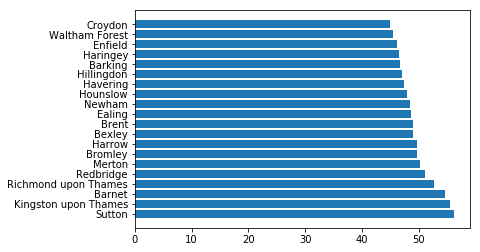

In [194]:
#Plot boroughs on a bar chart according to the average school performance score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
x = data['Borough']
y = data['Score']

plt.barh(x, y)
plt.show()

### Results

The k-means clustering has broken out the Outer London boroughs into five distinct clusters:  
  * Cluster 2. Typical English - plenty of parks and pubs, a sprinkling of cafés  
  * Cluster 3. Lively and vibrant - Lots of coffee places and a diverse selection of restaurants suggest these boroughs are multicultural  
  * Cluster 5. Suburbia - plenty of pubs, shops and restaurants but without the green spaces of cluster 2  
  * Clusters 1 & 4. Outliers - Not so much going on here. Areas could be very quiet  
  
The school performance results show the top four boroughs in terms of average school performance to be Sutton, Kingston upon Thames, Barnet, and Richmond upon Thames.

The clustering of the boroughs when combined with the school performance results is a very powerful tool to help families when relocating to London and choosing a place to live.
    

### Discussion

I would propose to revisit clusters 1 and 4 at a later time. I would spend more time to review the available data and refine the model  

I noted when collecting the venue information from Foursquare that I needed to increase the radius from the centre of each borough to capture a good number of results. This has been set to 2km. In a large city like London this is probably okay, but there is a risk of some overlap between the boroughs and I would take more time to see if 2km is the correct radius or if the model could be refined by changing it

### Conclusion

In conclusion the model is effective at analysing and grouping London boroughs into clusters to aid in narrowing down the choice of places to live for families with children. But there are other data sources that could be included to further improve the model, such as housing rental and purchase prices in each borough, crime statistics, etc.